## Zillow Sales versus List prices weekly for major US cities

In [6]:
# Loading in the basics
import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from config import password

In [7]:
# Connect to postgres db
ENDPOINT="ucb-data-group-project-zillow.csaw135fqqkl.us-west-1.rds.amazonaws.com"
PORT="5432"
USR="postgres"
REGION="us-west-1"


In [8]:
DBNAME="postgres"

conn = psycopg2.connect(database = DBNAME,
                        user =     USR,
                        password = password,
                        host =     ENDPOINT,
                        port =     PORT)

In [9]:
# list table sql
list_sql = '''
            SELECT *
            FROM list;
            '''

In [10]:
# sale table sql
sale_sql = '''
            SELECT *
            FROM sale;
            '''

In [11]:
# census table sql
census_sql = '''
            SELECT *
            FROM census;
            '''

In [13]:
# setting up dfs
list_df = pd.read_sql(list_sql, conn)
sale_df = pd.read_sql(sale_sql, conn)
census_df = pd.read_sql(census_sql, conn)

In [9]:
# general cleaning
list_df = list_df.drop(["region_date","region_id", "region_type"],1)
list_df.head()

,size_rank,region_name,state_name,date,price
0,0,United States,None,2017-11-04,275448.0
1,1,"New York, NY",NY,2017-11-04,526850.0
2,2,"Los Angeles-Long Beach-Anaheim, CA",CA,2017-11-04,812252.0
3,3,"Chicago, IL",IL,2017-11-04,319556.0
4,4,"Dallas-Fort Worth, TX",TX,2017-11-04,347537.0


In [10]:
# us data pullout for state listing price averaged

state_list = list_df.loc[list_df["region_name"] != "United States"]
state_list = state_list.drop(["region_name"], 1)
state_list = state_list.set_index("date").sort_index()
# .groupby("state_name", as_index = False).mean()

state_list = state_list.rename(columns = {"price":"list price"})
state_list.head()


,size_rank,state_name,list price
date,,,
2017-11-04,1,NY,526850.0
2017-11-04,70,OH,157843.0
2017-11-04,69,LA,237501.0
2017-11-04,68,TX,171751.0
2017-11-04,67,PA,250848.0


In [11]:
# Goal: make function that:
# 1) iterates through dataframe, grabbing state abbreviations into unique dataframes
# 2) collapse index(date) averaging int values

state_dict = {k: v for k, v in state_list.groupby("state_name")}

import pprint
pprint.pprint(state_dict)
# i think this works but frankly I've not used dicts very much. still need to collapse and average on date within the dataframe

{'AL':             size_rank state_name  list price
date                                        
2017-11-04         49         AL    221642.0
2017-11-11         49         AL    220129.0
2017-11-18         49         AL    218877.0
2017-11-25         49         AL    217584.0
2017-12-02         49         AL    217098.0
...               ...        ...         ...
2021-05-29         49         AL    296398.0
2021-06-05         49         AL    294475.0
2021-06-12         49         AL    292500.0
2021-06-19         49         AL    291225.0
2021-06-26         49         AL    289975.0

[191 rows x 3 columns],
 'AR':             size_rank state_name  list price
date                                        
2017-11-04         76         AR    165894.0
2017-11-11         76         AR    165986.0
2017-11-18         76         AR    165986.0
2017-11-25         76         AR    165986.0
2017-12-02         76         AR    166009.0
...               ...        ...         ...
2021-05-29      

In [12]:
pprint.pprint(state_dict["CA"])
# how do i collapse and average the dates?

            size_rank state_name  list price
date                                        
2017-11-04         66         CA    779777.0
2017-11-04         63         CA    265423.0
2017-11-04         56         CA    338397.0
2017-11-04         77         CA    408007.0
2017-11-04         17         CA    728005.0
...               ...        ...         ...
2021-06-26         13         CA    539520.0
2021-06-26         11         CA    995750.0
2021-06-26          2         CA    998350.0
2021-06-26         34         CA   1306875.0
2021-06-26         25         CA    622250.0

[1910 rows x 3 columns]


In [18]:
ca_list = state_dict["CA"].groupby(state_dict["CA"].index).mean()
tx_list = state_dict["TX"].groupby(state_dict["TX"].index).mean()
fl_list = state_dict["FL"].groupby(state_dict["FL"].index).mean()
ny_list = state_dict["NY"].groupby(state_dict["NY"].index).mean()
pn_list = state_dict["PN"].groupby(state_dict["PN"].index).mean()
il_list = state_dict["IL"].groupby(state_dict["IL"].index).mean()
oh_list = state_dict["OH"].groupby(state_dict["OH"].index).mean()
ga_list = state_dict["GA"].groupby(state_dict["GA"].index).mean()
nc_list = state_dict["NC"].groupby(state_dict["NC"].index).mean()


AttributeError: 'dict' object has no attribute 'groupby'

In [14]:
# couldn't find a good explanation on stackoverflow for my conundrum, so i posted the question. we'll see how that goes

In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, Flatten,LSTM,RepeatVector,TimeDistributed,Conv1D,MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# from livelossplot.keras import PlotLossesCallback

from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
df = stat_list
df = df.rename(columns = {"size_rank": "x"})
df = df.rename(columns = {"list price": "y"})


AttributeError: 'dict' object has no attribute 'rename'

In [ ]:
def train_test_builder(df,size_test=24,length_train_sequence = 24,length_forecast = 12, normalize = False):
    
    train_df = df[:-size_test]    
    
    # create training sets
    train_x,train_y = window_splitter(train_df)
    
    # create test set
    tmp = df[:length_forecast]
    tmp = pd.concat([df,tmp],ignore_index = True)
    tmp[-length_forecast:] = np.nan  # unknown
    test_x,test_y = window_splitter(tmp)
    # drop elements in training
    test_x = test_x[train_x.shape[0]:]
    test_y = test_y[train_x.shape[0]:]
    for i in range(length_forecast):
        test_y[i,:(11-i)]=np.nan # present in training_set
    
    # normalize
    if normalize:
        m = train_df.x.mean()
        sd = train_df.x.std()
        train_x -= m
        train_x/= sd
        test_x -=m
        test_x /= sd
    
    return train_x,train_y,test_x,test_y


# iterate over the time steps and divide the data into overlapping windows; 
def window_splitter(train_df,length_train_sequence = 24,length_forecast = 12):
    i = 0
    x,y = [],[]
    while i + length_train_sequence+ length_forecast < len(train_df):
        x.append(train_df.x[i:(i+length_train_sequence)].values)
        y.append(train_df.x[(i+length_train_sequence):(i+length_train_sequence+length_forecast)].values)
        i+=1

    x = np.array(x).reshape(-1,length_train_sequence,1)
    y = np.array(y).reshape(-1,length_forecast)
    
    return x,y

D:\anaconda\envs\ml_\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


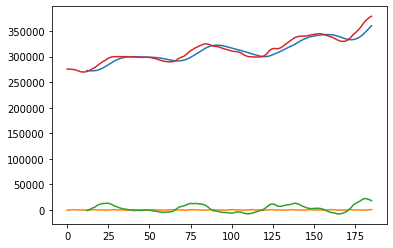

In [ ]:
# a naive seasonal decomposition
series = df.x.values
result = seasonal_decompose(series, model='additive',freq=12,two_sided = False,)
plt.plot(result.trend)
plt.plot(result.seasonal)
plt.plot(result.resid)
plt.plot(result.observed)

In [ ]:
train_x,train_y,test_x,test_y = train_test_builder(df)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((126, 24, 1), (126, 12), (36, 24, 1), (36, 12))

In [ ]:

# evaluation function
def evaluate_predictions(pred_y, test_y):
    return pd.DataFrame(abs(test_y-pred_y)).mean(skipna = True)


def plot_evaluation(pred_y,test_y,n=12):
    scores = evaluate_predictions(pred_y,test_y)

    print("Mean absolute error test set:",scores.mean())

    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1,13),scores)
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.ylabel("MAE", size = 15)
    plt.title("Scores LSTM on test set")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.title("LSTM forecasting - test set window")
    plt.plot(np.arange(1,13),pred_y[n:(n+1)].reshape(-1,1),label = "predictions")
    plt.plot(np.arange(1,13),test_y[n:(n+1)].reshape(-1,1),label = "true values")
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.legend()
    plt.show()

In [ ]:
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:

n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

# define model
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(None, 1)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs))

# compile
model.compile(loss='mse', optimizer= Adam(lr=1e-3), metrics = ["mae"])

# callbacks
early_stopping = EarlyStopping(patience=32, monitor='val_loss', mode='auto', restore_best_weights=True)
callbacks=[PlotLossesCallback(), early_stopping]

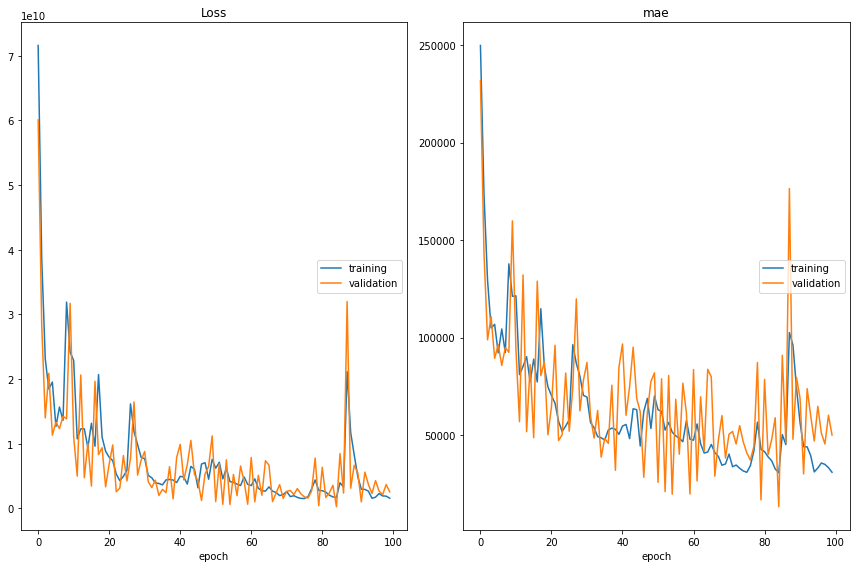

Loss
	training         	 (min: 1530685091.840, max: 71600450764.800, cur: 1574796116.480)
	validation       	 (min: 257807396.923, max: 60077627864.615, cur: 2563534178.462)
mae
	training         	 (min: 30743.725, max: 249795.734, cur: 30974.652)
	validation       	 (min: 13304.771, max: 231842.781, cur: 50036.000)
100/100 [==============================] - 1s 7ms/sample - loss: 1574796116.4800 - mae: 30974.6523 - val_loss: 2563534178.4615 - val_mae: 50036.0000


In [ ]:
model.fit(train_x, train_y, 
          validation_split = 0.2, 
          epochs=100, 
          shuffle = True,
          batch_size=16,
          verbose=1,
          callbacks = callbacks,
         )

Mean absolute error test set: 33331.24989583333


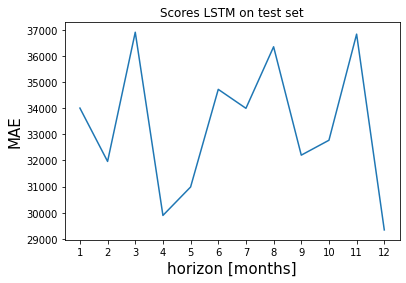

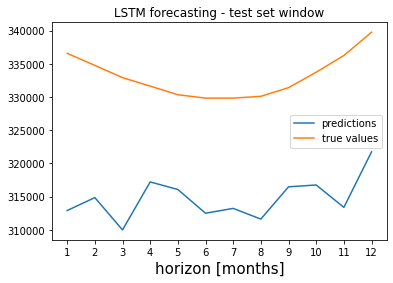

In [ ]:
pred_y = model.predict(test_x)
# add seasonality of the past year
for i in np.arange(pred_y.shape[0]-1,-1,-1):
    pred_y[pred_y.shape[0]-1-i] += result.seasonal[-(13+i):-(1+i)]

plot_evaluation(pred_y,test_y,n=12)


In [ ]:
# node count: ???
# activation method: swish
# gist per austin: 100~200, nodes: play with, hidden layers: 1~2 max 3